#**Load the COCO dataset for Retrieval demo**

In [1]:
! touch configs.py costum_datasets.py text_image.py text_image_audio.py text_image_video.py text_image_radio.py

In [2]:
! mkdir datasets
! mkdir datasets/annotations
! mkdir datasets/train2014
! mkdir datasets/val2014

In [3]:
# Dowload coco dataset
from costum_datasets import download_dataset
download_dataset("datasets")

In [35]:
# Construct pairs of text and image
from configs import CFG
from costum_datasets import make_pairs
training_pairs = make_pairs(CFG.train_annotation_file, CFG.image_dir, 5) # 413.915 -> 82.783 images

loading annotations into memory...
Done (t=1.67s)
creating index...
index created!


In [36]:
# Sorted according images
training_pairs = sorted(training_pairs, key=lambda x: x[0])

In [37]:
coco_images, coco_captions = zip(*training_pairs)

In [38]:
# Take unique images
unique_images = set()
unique_pairs = [(item[0], item[1]) for item in training_pairs if item[0] not in unique_images
                and not unique_images.add(item[0])]

coco_images, _ = zip(*unique_pairs)

len(coco_images)

82783

# **Text - Image**

**<h2>Load Model</h2>**

In [5]:
from text_image import OneEncoder
from configs import CFG
import torch
"""
This model is trained with temperature = 1.0.
Temperature = 1.0 gives better results for matching and is more confident
"""
model = OneEncoder.from_pretrained("bilalfaye/OneEncoder")

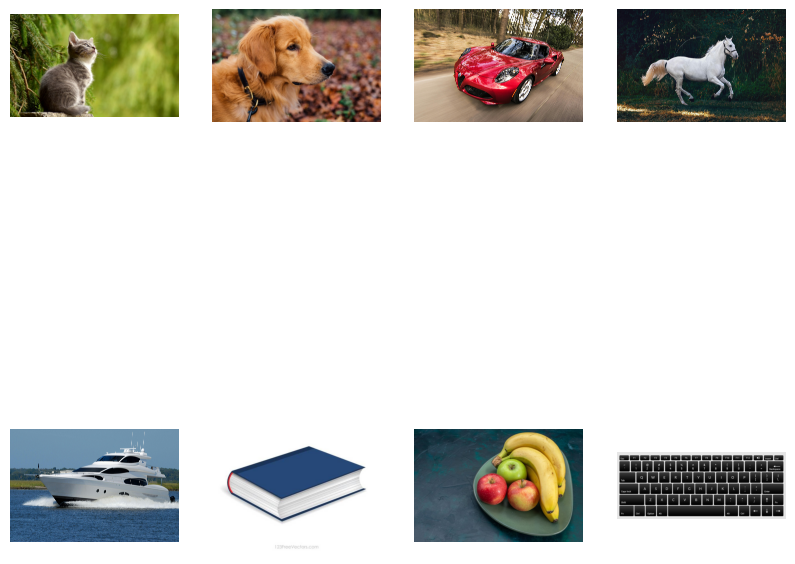

In [6]:
# Load some images for test
import matplotlib.pyplot as plt
image_paths = [
    "https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_1280.jpg",
    "https://images.all-free-download.com/images/graphiclarge/adorable_animal_breed_canine_cute_dog_doggy_603714.jpg",
    "https://images.pexels.com/photos/210019/pexels-photo-210019.jpeg?cs=srgb&dl=pexels-pixabay-210019.jpg&fm=jpg",
    "https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg",
    "https://images.pexels.com/photos/163236/luxury-yacht-boat-speed-water-163236.jpeg?cs=srgb&dl=pexels-pixabay-163236.jpg&fm=jpg",
    "https://i.pinimg.com/736x/81/a7/4a/81a74a1948bea28626d9aa2008191c09.jpg",
    "https://img.freepik.com/free-photo/front-view-different-fruit-composition-apples-bananas-dark-blue-desk-fruit-fresh-mellow-exotic-tropical_140725-53049.jpg",
    "https://t4.ftcdn.net/jpg/03/11/60/31/360_F_311603103_BoOOZ7Kzg9AKmAFLtjKshuGBFJWOGlHI.jpg"
]
fig, axes = plt.subplots(2, 8//2, figsize=(10, 10))

for image, ax in zip(image_paths, axes.flatten()):
      image = model.load_image(image)
      ax.imshow(image)
      ax.axis("off")
plt.show()

**<h2>Encode Text - Image - Audio</h2>**

In [7]:
# Encode the two first images
sequence_outputs = model.encode_image(image_paths=image_paths[:2], outputs="sequence")
vector_outputs = model.encode_image(image_paths=image_paths[:2], outputs="vector") # vector or mean
print("Sequence outputs: ", sequence_outputs.shape)
print("Vector outputs: ", vector_outputs.shape)

Sequence outputs:  torch.Size([2, 197, 256])
Vector outputs:  torch.Size([2, 256])


In [8]:
# Encode batch of texts
sequence_outputs = model.encode_text(texts=["a cat", "a dog"], outputs="average")
vector_outputs = model.encode_text(texts=["a cat", "a dog"], outputs="vector") # vector or mean
print("Sequence outputs: ", sequence_outputs.shape)
print("Vector outputs: ", vector_outputs.shape)

Sequence outputs:  torch.Size([2, 256])
Vector outputs:  torch.Size([2, 256])


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

texts = ["cat", "dog", "car", "horse", "boat", "book", "banana", "apple", "keyboard"]
def match_and_plot(image_path, texts=texts, model=model, temperature=0.0):
    """
    Perform matching between an image and a set of texts using a given model,
    then visualize the similarity scores using a bar plot.

    Parameters:
        image_path (str): Path to the input image.
        texts (list of str): List of text labels to match against.
        model: The matching model with a `matching` method.
    """

    # Perform the matching
    probs, indices = model.matching(image_paths=[image_path],
                                    texts=[f"{text}" for text in texts],
                                    top_k=len(texts),
                                    temperature=temperature)

    # Prepare the similarity scores dictionary
    similarity_scores = {text: 0 for text in texts}  # Initialize all to 0
    for prob, index in zip(probs.cpu().ravel().tolist(), indices[0].tolist()):
        similarity_scores[texts[index]] = prob  # Assign the correct probability

    # Convert to DataFrame
    df = pd.DataFrame(list(similarity_scores.items()), columns=['Objects', 'Similarity Scores'])

    # Plot the results
    plt.figure(figsize=(15, 6))
    sns.set_theme(style="darkgrid")
    barplot = sns.barplot(x='Objects', y='Similarity Scores', data=df, color='blue')

    # Formatting
    barplot.set(xlabel='', ylabel='')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    # Display the plot
    plt.show()

**<h2>Matching Text and Image</h2>**

In [10]:
match_and_plot(image_paths[0])

In [11]:
match_and_plot(image_paths[1])

In [12]:
match_and_plot(image_paths[2])

In [13]:
match_and_plot(image_paths[3])

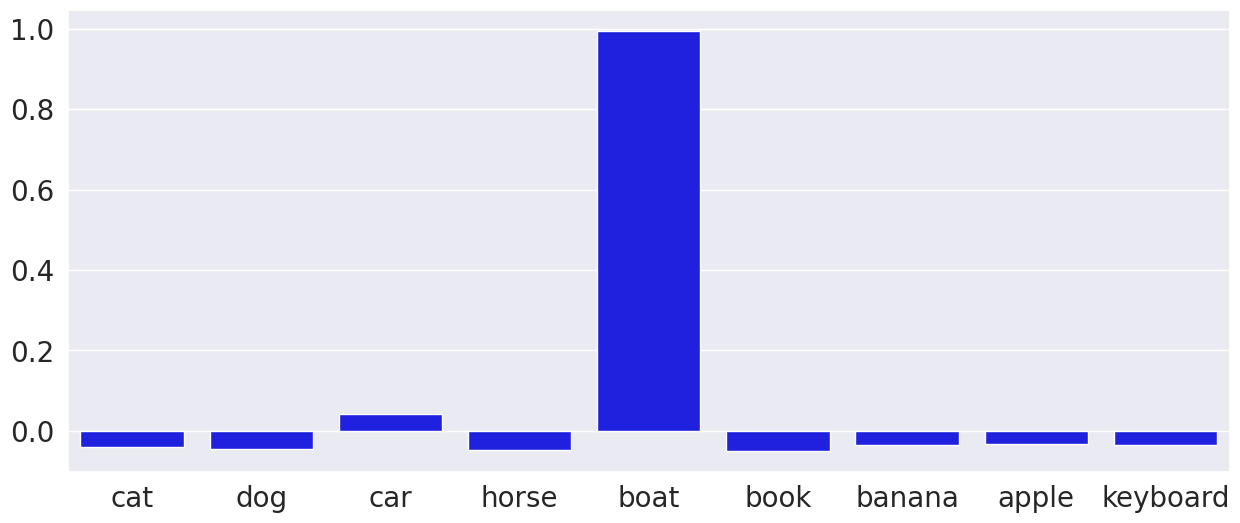

In [14]:
match_and_plot(image_paths[4])

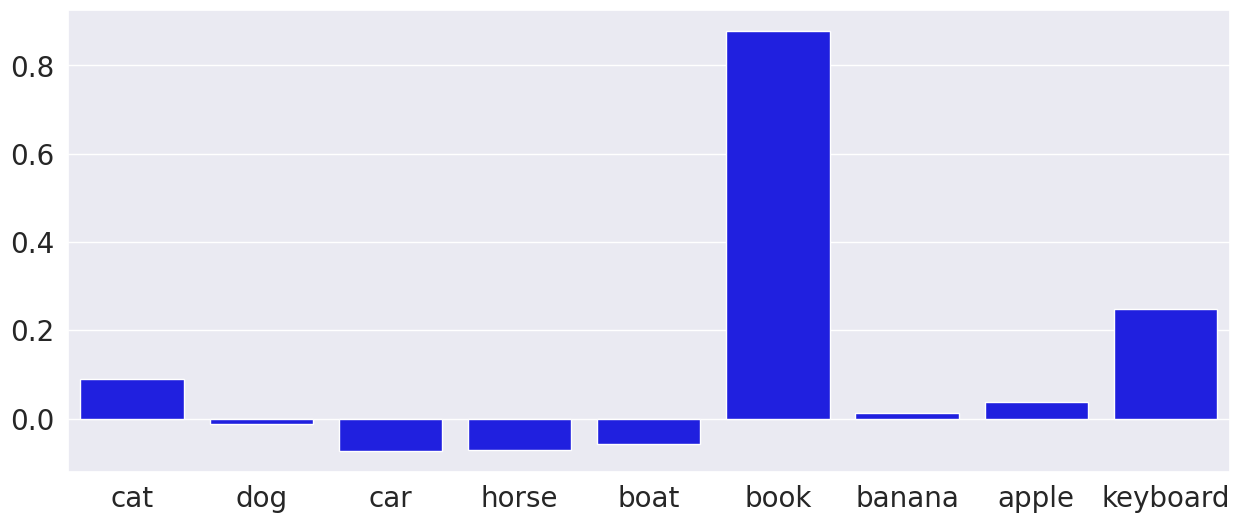

In [15]:
match_and_plot(image_paths[5])

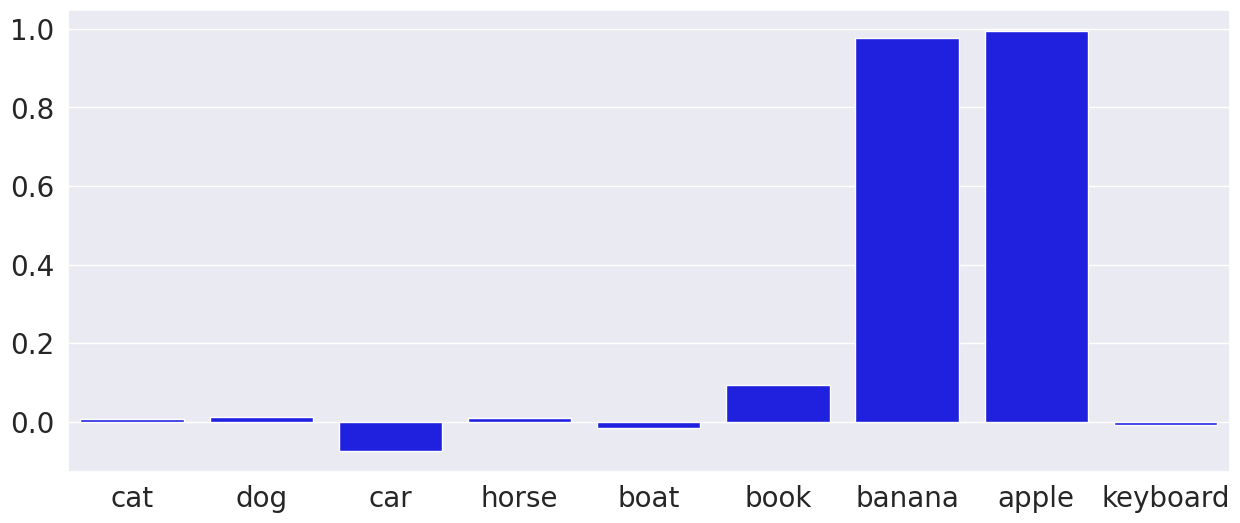

In [16]:
match_and_plot(image_paths[6])

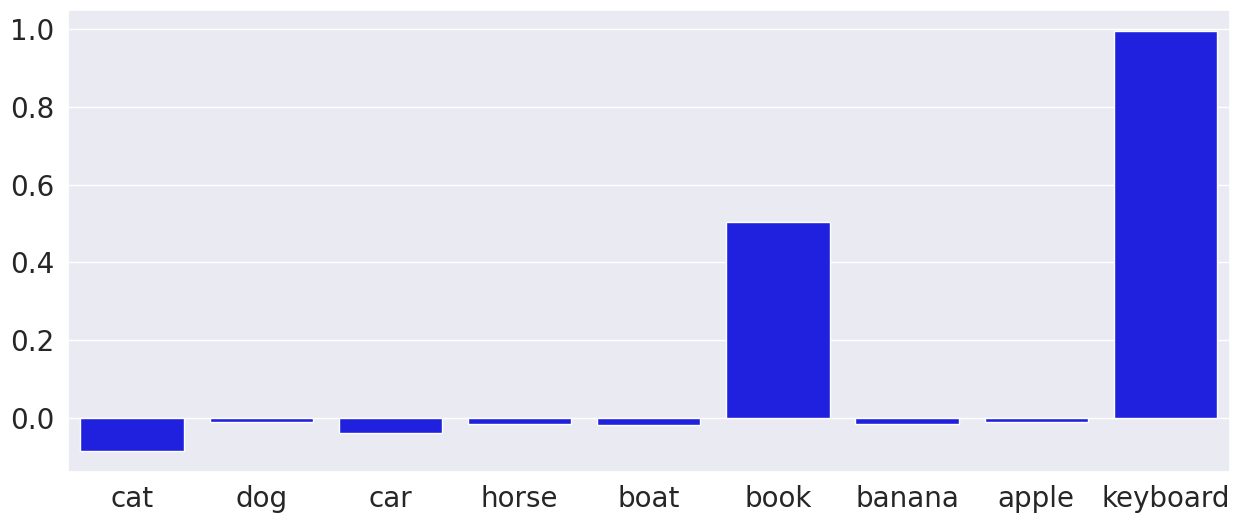

In [17]:
match_and_plot(image_paths[7])

In [18]:
# Matching between images and texts
probs, indices = model.matching(image_paths=image_paths,
                                texts=["Cat", "Dog", "Car", "Horse", "Boat", "Book", "Banana", "Apple", "Keyboard"],
                                top_k=3,
                                temperature=0.0)
print("Probabilities:\n", probs)
print("Indices:\n", indices)

Probabilities:
 tensor([[ 0.9761,  0.0642,  0.0033],
        [ 0.9550,  0.0732,  0.0304],
        [ 0.9764,  0.0634,  0.0032],
        [ 0.9318,  0.0682,  0.0130],
        [ 0.9945,  0.0425, -0.0326],
        [ 0.8784,  0.2491,  0.0892],
        [ 0.9949,  0.9777,  0.0952],
        [ 0.9956,  0.5039, -0.0116]])
Indices:
 tensor([[0, 1, 2],
        [1, 0, 3],
        [2, 4, 1],
        [3, 1, 0],
        [4, 2, 7],
        [5, 8, 0],
        [7, 6, 5],
        [8, 5, 7]])


**<h2>Retrieval</h2>**

In [19]:
# Image retrieval
probs, indices = model.image_retrieval(query="this is a cat", image_paths=image_paths, n=8, temperature=0.0)
print("Probalities", probs)
print("Indices", indices)

Probalities tensor([ 0.9759,  0.0594,  0.0472,  0.0175,  0.0080, -0.0019, -0.0345, -0.0749])
Indices tensor([0, 1, 5, 3, 6, 2, 4, 7])


In [20]:
# Image retrieval
probs, indices = model.image_retrieval(query="this is a cat",
                                       image_paths=image_paths,
                                       n=2,
                                       plot=True,
                                       temperature=0.0)

In [21]:
# Text retrieval
texts = ["Cat", "Dog", "Car", "Horse", "Boat", "Book", "Banana", "Apple", "Keyboard"]
texts, values = model.text_retrieval(query=image_paths[0], texts=[f"this is a {text}" for text in texts], n=1, temperature=0.0)
print("Text:", texts)
print("Probs:", values)

Text: ['this is a Cat']
Probs: tensor([0.9759])


**<h2>Matching Images to CoCo categories</h2>**

In [22]:
# Encode texts
coco_categories = [
    "Person", "Bicycle", "Car", "Motorcycle", "Airplane", "Bus", "Train", "Truck",
    "Boat", "Traffic light", "Fire hydrant", "Stop sign", "Parking meter", "Bench",
    "Bird", "Cat", "Dog", "Horse", "Sheep", "Cow", "Elephant", "Bear", "Zebra",
    "Giraffe", "Backpack", "Umbrella", "Handbag", "Tie", "Suitcase", "Frisbee", "Skis",
    "Snowboard", "Sports ball", "Kite", "Baseball bat", "Baseball glove", "Skateboard",
    "Surfboard", "Tennis racket", "Bottle", "Wine glass", "Cup", "Fork", "Knife", "Spoon",
    "Bowl", "Banana", "Apple", "Sandwich", "Orange", "Broccoli", "Carrot", "Hot dog", "Pizza",
    "Donut", "Cake", "Chair", "Couch", "Potted plant", "Bed", "Dining table", "Toilet", "TV",
    "Laptop", "Mouse", "Remote", "Keyboard", "Cell phone", "Microwave", "Oven", "Toaster",
    "Sink", "Refrigerator", "Book", "Clock", "Vase", "Scissors", "Teddy bear", "Hair drier",
    "Toothbrush"
]

In [23]:
probs, indices = model.matching(image_paths=image_paths,
                                    texts=coco_categories,
                                    top_k=5,
                                    temperature=0.0)

In [24]:
import numpy as np
sns.reset_defaults()
plt.figure(figsize=(12, 12))

for i, image in enumerate(image_paths):
    plt.subplot(4, 4, 2 * i + 1)
    image = model.load_image(image)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(probs.shape[-1])
    plt.grid()
    plt.barh(y, probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [coco_categories[index] for index in indices[i].numpy()])
    # plt.xlabel("probability")
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)

plt.subplots_adjust(wspace=1.0)
plt.show()

**<h2>Measure of similarity between Texts and Images</h2>**

In [25]:
import matplotlib.pyplot as plt
from skimage import data
from skimage import img_as_ubyte
import numpy as np

descriptions = {
    "page": "a page of segmentation text",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "A female astronaut with a red jacket",
    "rocket": "a rocket standing on a launchpad",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer",
    "eagle": "an image of an eagle"
}

images = []
texts = []
plt.figure(figsize=(16, 5))

# List of available images in skimage.data
image_dict = {
    "page": data.page(),
    "chelsea": data.chelsea(),
    "astronaut": data.astronaut(),
    "rocket": data.rocket(),
    "camera": data.camera(),
    "horse": data.horse(),
    "coffee": data.coffee(),
    "eagle": data.eagle()
}

for i, (name, image) in enumerate(image_dict.items()):
    if name not in descriptions:
        continue

    plt.subplot(2, 4, len(images) + 1)

    # Ensure the image is in uint8 format
    if image.dtype != np.uint8:
        image = img_as_ubyte(image)

    # Convert grayscale to RGB if necessary
    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)

    plt.imshow(image)
    plt.title(f"{name}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    images.append(image)
    texts.append(descriptions[name])

plt.tight_layout()
plt.show()


In [26]:
# Encode images
image_processed = [model.image_preprocessor(image=image)["image"] for image in images]
image_processed = torch.stack(image_processed)
image_features = model.encode_image(image_tensors=image_processed, outputs="mean")
image_features.shape

torch.Size([8, 256])

In [27]:
# Encode Texts
text_features = model.encode_text(texts=texts, outputs="mean")
text_features.shape

torch.Size([8, 256])

In [28]:
# Calculate similarities
import torch.nn.functional as F
image_features = F.normalize(image_features, p=2, dim=-1)
text_features = F.normalize(text_features, p=2, dim=-1)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Calculate similarities
count = len(descriptions)
plt.figure(figsize=(20, 10))

# Use plt.imshow for the similarity matrix with a Seaborn colormap
cmap = sns.color_palette("coolwarm", as_cmap=True)
plt.imshow(similarity, cmap=cmap, vmin=0.1, vmax=1.0)

# Add colorbar with adjusted length
cbar = plt.colorbar(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
#cbar.set_label('Similarity', rotation=270, labelpad=10)

plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])

# Plot images
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# Add text annotations
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

# Remove spines
for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

# Add title if needed
# plt.title("Cosine similarity between text and image features", size=20)
plt.show()


**<h2>Text and Image Retrieval</h2>**

In [ ]:
from text_image import OneEncoder
from configs import CFG
import torch
"""
This model is trained with temperature = 2.5.
Temperature = 2.5 is better for retrieval and step 2 (adding other modalities)
"""
model = OneEncoder.from_pretrained("bilalfaye/OneEncoder-text-image")

In [31]:
# Examples
queries = {
    0: "an ocean",
    1:"a cat",
    2:"a dog",
    3:"a white dog",
    4:"one dog sitting on the grass",
    5:"two dog sitting on the grass",
    6: "a family standing next to the ocean on a sandy beach with a surf board",
    7: "a group of people dancing in a party",
    8: "a train",
    9: "an apple",
    10: "a red apple",
    11: "a green apple",
    12: "the company apple",
    13: "a giraffe in the forest",
    14: "a giraffe in a house",

    15: 'a stunning golden sunset over the calm ocean waves',
    16: 'a joyful family enjoying a lovely picnic in the park',
    17: "an adorable puppy happily chasing a ball in the backyard",
    18: "an enchanting view of a historic city with charming architecture",
    19: "a vibrant hot air balloon festival filling the sky with a burst of colors",

    20: "at the beach, a group of friends is having fun, playing beach volleyball, and constructing sandcastles",
    21: "enjoying a day at the seashore, a bunch of friends engages in beach volleyball and constructs sandcastles",
    22: "on the sandy beach, friends have a great time playing beach volleyball and building sandcastles",

    23: "a cat sitting on a bookshelf next to a vase of flowers",
    24: "children playing on the beach, with the ocean waves crashing behind them",
    25: "a family having a picnic under a shady tree in the park",
    26: "a dog running outside the house, chasing after a ball",

    27: "a cozy living room",
    28: "a cozy living room with a fireplace",
    29: "a cat sleeping on the sofa",
    30: "a cozy living room with a fireplace and a cat sleeping on the sofa",

    31: "a dog in the house",
    32: "a dog out the house",
    33:"a dog next to the door",
    34: "a dog and a cat"

}

In [ ]:
# Load image features
import os
path = "."
coco_image_features = torch.load(os.path.join(path, "image_embeddings_best.pt"), map_location=CFG.device)
coco_image_features.shape

<ipython-input-32-aecf1830fa92>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coco_image_features = torch.load(os.path.join(path, "image_embeddings_best.pt"), map_locatio

torch.Size([82783, 256])

In [33]:
# Load text features
coco_text_features = torch.load(os.path.join(path, "caption_embeddings_best.pt"), map_location=CFG.device)
coco_text_features.shape

<ipython-input-33-1b3f7dec973a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coco_text_features = torch.load(os.path.join(path, "caption_embeddings_best.pt"), map_locati

torch.Size([413915, 256])

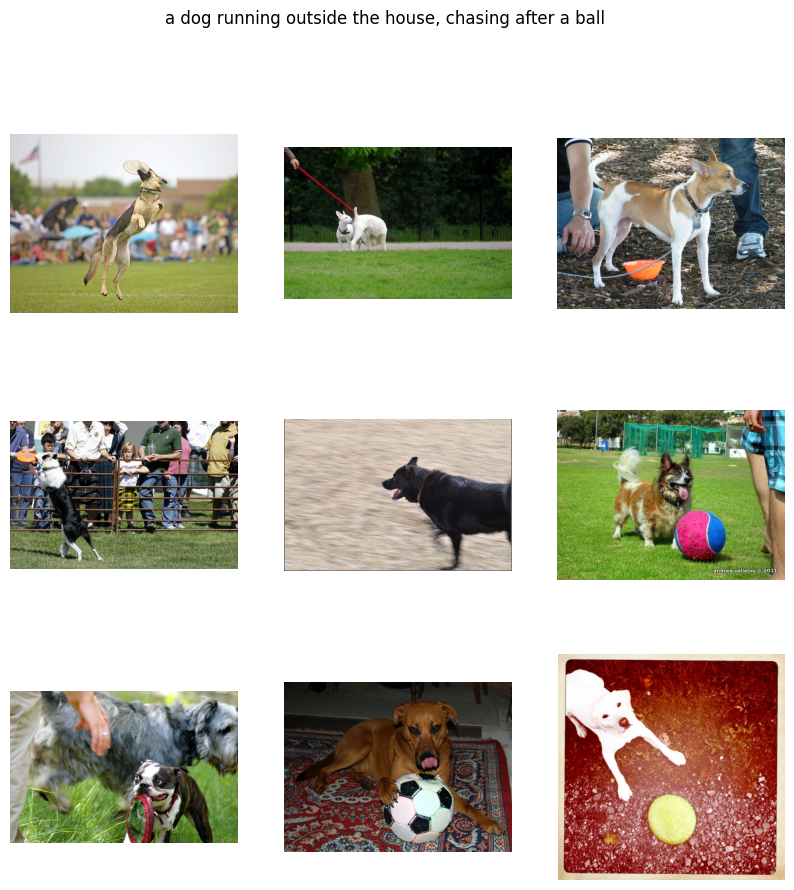

In [ ]:
import numpy as np
probs, indices = model.image_retrieval(queries[np.random.randint(34)], image_paths=coco_images,
                                       image_embeddings=coco_image_features, n=9, plot=True,
                                       temperature=0.0)

In [ ]:
# Text retrieval : Giving text features
texts, probs = model.text_retrieval(coco_images[np.random.randint(len(coco_images))], coco_captions,
                     text_embeddings=coco_text_features, n=5, plot_image=True, temperature=0.0)

# Matched Texts with probalities
for text, prob in zip(texts, probs):
  print(f"{prob:.2f}: {text}")

0.81: Guys in the woods are looking at their phones, probably trying to use a gps feature. 
0.78: Two outdoorsmen check their cell phones on a grassy lawn.
0.78: Guys standing in the patch looking at their phones
0.78: some people a tree and one male is talking on his cellphone
0.76: A man and a woman standing near a tree. 


# **Text - Image - Audio**

**<h2>Load the model</h2>**

In [ ]:
from text_image_audio import OneEncoder
from configs import CFG
import torch

model = OneEncoder.from_pretrained("bilalfaye/OneEncoder-text-image-audio")

**<h2>Convert Text to Audio</h2>**

In [85]:
import tempfile
import soundfile as sf

def text_to_audio(model,
                  wav_processor,
                  text,
                  text_processor,
                  audio_generator,
                  vocoder,
                  speaker_embeddings,
                  save_audio=False,
                  audio_save_path="audio.wav"):
    if not save_audio:
        # Save the audio data to a temporary file
        with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp_audio_file:
            inputs = text_processor(text=text, return_tensors="pt")
            speech = audio_generator.generate_speech(inputs["input_ids"], speaker_embeddings,
                                                          vocoder=vocoder)
            sf.write(tmp_audio_file.name, speech.numpy(), samplerate=model.sample_rate)
            file_name = tmp_audio_file.name
    else:
            inputs = text_processor(text=text, return_tensors="pt")
            speech = audio_generator.generate_speech(inputs["input_ids"], speaker_embeddings,
                                                          vocoder=vocoder)
            sf.write(audio_save_path, speech.numpy(), samplerate=model.sample_rate)
            file_name = audio_save_path

    # Load the audio file
    audio_input = model.load_audio(file_name).squeeze().numpy()
    audio_encoding = model.process_audio([audio_input])
    return audio_encoding

In [ ]:
! pip install datasets

In [47]:
from transformers import AutoProcessor, SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
from datasets import load_dataset
# Parameters
wav_processor = AutoProcessor.from_pretrained(CFG.audio_name)
text_processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
audio_generator = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

In [48]:
# Example
from IPython.display import Audio
text_to_audio_spectrogram = text_to_audio(model=model,
                                          wav_processor=wav_processor,
                                          text="This is a black dog",
                                          text_processor=text_processor,
                                          audio_generator=audio_generator,
                                          vocoder=vocoder,
                                          speaker_embeddings=speaker_embeddings,
                                          save_audio=True)
Audio("audio.wav")

In [13]:
text_to_audio_spectrogram['input_values'].shape

torch.Size([1, 22016])

**<h2> Load some Images for Test</h2>**

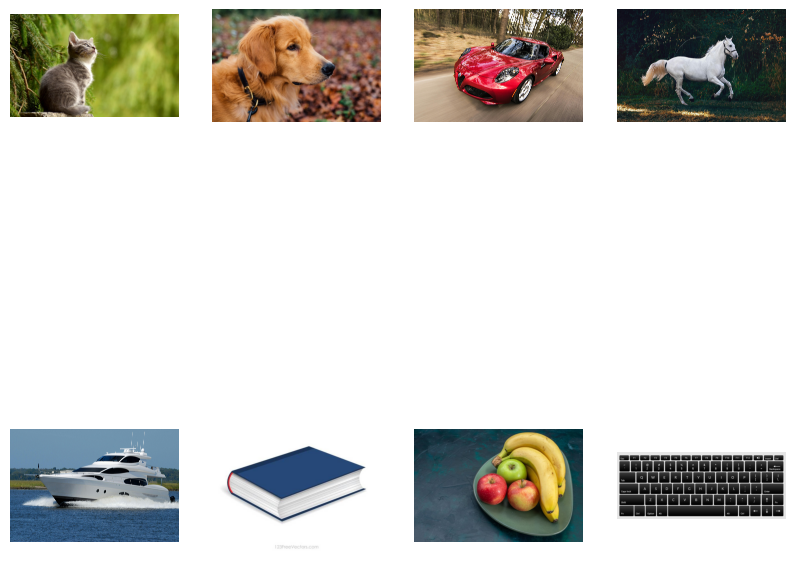

In [49]:
# Load some images for test
import matplotlib.pyplot as plt
image_paths = [
    "https://cdn.pixabay.com/photo/2017/02/20/18/03/cat-2083492_1280.jpg",
    "https://images.all-free-download.com/images/graphiclarge/adorable_animal_breed_canine_cute_dog_doggy_603714.jpg",
    "https://images.pexels.com/photos/210019/pexels-photo-210019.jpeg?cs=srgb&dl=pexels-pixabay-210019.jpg&fm=jpg",
    "https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg",
    "https://images.pexels.com/photos/163236/luxury-yacht-boat-speed-water-163236.jpeg?cs=srgb&dl=pexels-pixabay-163236.jpg&fm=jpg",
    "https://i.pinimg.com/736x/81/a7/4a/81a74a1948bea28626d9aa2008191c09.jpg",
    "https://img.freepik.com/free-photo/front-view-different-fruit-composition-apples-bananas-dark-blue-desk-fruit-fresh-mellow-exotic-tropical_140725-53049.jpg",
    "https://t4.ftcdn.net/jpg/03/11/60/31/360_F_311603103_BoOOZ7Kzg9AKmAFLtjKshuGBFJWOGlHI.jpg"
]
fig, axes = plt.subplots(2, 8//2, figsize=(10, 10))

for image, ax in zip(image_paths, axes.flatten()):
      image = model.text_image_encoder.load_image(image)
      ax.imshow(image)
      ax.axis("off")
plt.show()

**<h2>Encode an Audio using Alignment Layer and Universal Projection</h2>**

In [15]:
# Encode audio
outputs = model.encode_audio(audios=text_to_audio_spectrogram)
outputs.shape

torch.Size([1, 68, 256])

**<h2>Matching</h2>**

In [16]:
class_names = ["cat", "dog", "car", "horse", "boat", "book", "banana", "apple", "keyboard"]
labels = [f"a photo of a {label}" for label in class_names]
audio_names = [f"{class_name}.wav" for class_name in class_names]
for label, audio_name in zip(labels, audio_names):
    text_to_audio_spectrogram = text_to_audio(model=model,
                                              wav_processor=wav_processor,
                                              text=label,
                                              text_processor=text_processor,
                                              audio_generator=audio_generator,
                                              vocoder=vocoder,
                                              speaker_embeddings=speaker_embeddings,
                                              save_audio=True,
                                              audio_save_path=audio_name)

# Display audios
for audio in audio_names:
    display(Audio(audio))

**<h3>Matching Image and Audio</h3>**

In [51]:
# Encode audios
audios = []
for audio_name in audio_names:
    waveform = model.load_audio(audio_name).squeeze().numpy()
    audios.append(waveform)

audios = model.process_audio(audios)

In [52]:
audios

{'input_values': tensor([[ 0.0027,  0.0065,  0.0042,  ...,  0.0005,  0.0005,  0.0005],
        [ 0.0004,  0.0056,  0.0056,  ...,  0.0004,  0.0004,  0.0004],
        [ 0.0015,  0.0059,  0.0071,  ...,  0.0003,  0.0003,  0.0003],
        ...,
        [ 0.0088,  0.0163,  0.0136,  ..., -0.0101, -0.0053, -0.0080],
        [ 0.0046,  0.0098,  0.0098,  ...,  0.0001,  0.0001,  0.0001],
        [ 0.0033,  0.0103,  0.0049,  ...,  0.0003,  0.0003,  0.0003]])}

In [53]:
# Matching image and audio
# To read the output raw is images and columns is audios

probs, indices = model.matching_image_audio(
                                      audios=audios,
                                      image_paths=image_paths,
                                      top_k=3,
                                      strategy="softmax",
                                      temperature=0.0
                                      )
print("Probabilities:\n", probs)
print("Indices:\n", indices)

Probabilities:
 tensor([[0.7418, 0.0638, 0.0523],
        [0.9485, 0.0156, 0.0088],
        [0.9379, 0.0141, 0.0136],
        [0.9385, 0.0276, 0.0077],
        [0.9900, 0.0025, 0.0019],
        [0.3162, 0.1536, 0.1415],
        [0.5383, 0.3877, 0.0384],
        [0.8623, 0.0467, 0.0414]], grad_fn=<TopkBackward0>)
Indices:
 tensor([[0, 1, 2],
        [1, 6, 0],
        [2, 8, 0],
        [3, 1, 7],
        [4, 2, 0],
        [8, 0, 5],
        [6, 7, 8],
        [8, 0, 7]])


**<h3>Matching Text and Audio</h3>**

In [54]:
# Matching text and audio
# To read the output raw is texts and columns is audios
probs, indices = model.matching_text_audio(
                                     audios=audios,
                                     texts=labels,
                                     top_k=3,
                                     strategy="softmax",
                                     temperature=0.0)
print("Probabilities:\n", probs)
print("Indices:\n", indices)

Probabilities:
 tensor([[0.7292, 0.1441, 0.0421],
        [0.9033, 0.0284, 0.0120],
        [0.9121, 0.0192, 0.0158],
        [0.9142, 0.0363, 0.0148],
        [0.9635, 0.0106, 0.0079],
        [0.8720, 0.0220, 0.0213],
        [0.9036, 0.0338, 0.0131],
        [0.9662, 0.0146, 0.0084],
        [0.7587, 0.0982, 0.0689]], grad_fn=<TopkBackward0>)
Indices:
 tensor([[0, 1, 5],
        [1, 0, 2],
        [2, 0, 4],
        [3, 1, 0],
        [4, 5, 2],
        [5, 0, 7],
        [6, 5, 7],
        [7, 6, 8],
        [8, 5, 7]])


**<h2>Image Retrieval</h2>**


In [55]:
# Examples
queries = {
    0: "an ocean",
    1:"a cat",
    2:"a dog",
    3:"a white dog",
    4:"one dog sitting on the grass",
    5:"two dog sitting on the grass",
    6: "a family standing next to the ocean on a sandy beach with a surf board",
    7: "a group of people dancing in a party",
    8: "a train",
    9: "an apple",
    10: "a red apple",
    11: "a green apple",
    12: "the company apple",
    13: "a giraffe in the forest",
    14: "a giraffe in a house",

    15: 'a stunning golden sunset over the calm ocean waves',
    16: 'a joyful family enjoying a lovely picnic in the park',
    17: "an adorable puppy happily chasing a ball in the backyard",
    18: "an enchanting view of a historic city with charming architecture",
    19: "a vibrant hot air balloon festival filling the sky with a burst of colors",

    20: "at the beach, a group of friends is having fun, playing beach volleyball, and constructing sandcastles",
    21: "enjoying a day at the seashore, a bunch of friends engages in beach volleyball and constructs sandcastles",
    22: "on the sandy beach, friends have a great time playing beach volleyball and building sandcastles",

    23: "a cat sitting on a bookshelf next to a vase of flowers",
    24: "children playing on the beach, with the ocean waves crashing behind them",
    25: "a family having a picnic under a shady tree in the park",
    26: "a dog running outside the house, chasing after a ball",

    27: "a cozy living room",
    28: "a cozy living room with a fireplace",
    29: "a cat sleeping on the sofa",
    30: "a cozy living room with a fireplace and a cat sleeping on the sofa",

    31: "a dog in the house",
    32: "a dog out the house",
    33:"a dog next to the door",
    34: "a dog and a cat"

}

In [ ]:
# Load coco image features
coco_image_features = torch.load("image_embeddings_best.pt", map_location=CFG.device)
coco_image_features.shape

In [ ]:
import numpy as np
from torch.nn import functional as F
from IPython.display import Audio
text = queries[np.random.randint(34)]
text_to_audio_spectrogram = text_to_audio(model=model,
                                          wav_processor=wav_processor,
                                          text=text,
                                          text_processor=text_processor,
                                          audio_generator=audio_generator,
                                          vocoder=vocoder,
                                          speaker_embeddings=speaker_embeddings,
                                          save_audio=True,
                                          audio_save_path="query.wav")

probs, indices = model.image_retrieval(text_to_audio_spectrogram, image_paths=coco_images,
                                       image_embeddings=coco_image_features, n=9, plot=True, temperature=0.0, display_audio=True)

# **Text - Image - Audio - Video**

#**Text - Image - Audio - Video - Radio**